<a href="https://colab.research.google.com/github/SpadavecchiaAdrian/NDVI-in-python/blob/master/NDVI_Landsat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

main starting link:

**https://geohackweek.github.io/raster/04-workingwithrasters/**

Where to look for the images ?:
https://landsatonaws.com/

What is the path and row of Mendoza ?: https://landsatonaws.com/L8/232/083/ 

# Install dependency 
Google Colab is a virtual machine, which brings some dependencies already installed as for example TensorFlow, in our case study we need the following dependencies to allow us to work with rasterios. 

The following cell installs dependencies in the VM Colab through pip, the command ""! "" Indicates that the code is executed in shell.



In [0]:
#install rasterio, pyproj, Fiona

!pip install rasterio
!pip install pyproj
!pip install Fiona
!pip install geopandas

     |████████████████████████████████| 16.8MB 3.6MB/s 
     |████████████████████████████████| 9.8MB 4.7MB/s 
     |████████████████████████████████| 17.9MB 4.7MB/s 
  Created wheel for munch: filename=munch-2.3.2-py2.py3-none-any.whl size=6613 sha256=65bcecb7f87004a2b8741eab86e2e7877702705ec26a478cd491e181792c5318
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built munch
     |████████████████████████████████| 901kB 4.8MB/s 


# Import
We import libraries and modules.

In [0]:
import rasterio       
import rasterio.plot  
from rasterio.mask import mask
import pyproj
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import fiona
from fiona.crs import from_epsg
from pyproj import Proj, transform

%matplotlib inline


# Basic work
This section is intended to review the main operations with the rasterios module.


## Get the profile of a GeoTiff

In [0]:
#URL address where the GeoTiff is located in this case is an aws server

filepath = 'http://landsat-pds.s3.amazonaws.com/c1/L8/232/083/LC08_L1TP_232083_20181231_20190130_01_T1/LC08_L1TP_232083_20181231_20190130_01_T1_B4.TIF'

with rasterio.open(filepath) as src:
    print('Landsat on AWS:')
    print(src.profile)

Landsat on AWS:
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7741, 'height': 7801, 'count': 1, 'crs': CRS.from_epsg(32619), 'transform': Affine(30.0, 0.0, 370485.0,
       0.0, -30.0, -3554085.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


## Plot low resolution data (thumbnail)
(Only in aws server) 
AWS servers maintain a series of reduced images that allow a preview without downloading a whole GeoTiff of approx 1Gb

Overviews decimator factor:
[3, 9, 27, 81]
Decimation factor= 81
array type:  <class 'numpy.ndarray'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Text(0, 0.5, 'Row #')

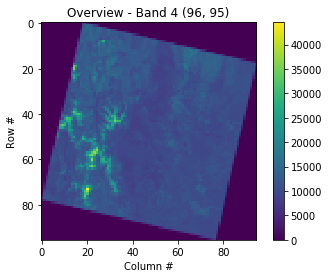

In [0]:
#URL address where the GeoTiff is located in this case is an aws server
filepath = 'http://landsat-pds.s3.amazonaws.com/c1/L8/232/083/LC08_L1TP_232083_20181231_20190130_01_T1/LC08_L1TP_232083_20181231_20190130_01_T1_B4.TIF'


# The grid of raster values can be accessed as a numpy array and plotted:
with rasterio.open(filepath) as src:
  oviews = src.overviews(1) # list of overviews from biggest to smallest
  print("Overviews decimator factor:")
  print(oviews)
  oview = oviews[-1] # let's look at the smallest thumbnail (81)
  print('Decimation factor= {}'.format(oview))
  # NOTE this is using a 'decimated read' (http://rasterio.readthedocs.io/en/latest/topics/resampling.html)
  thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

print('array type: ',type(thumbnail))
print(thumbnail)

plt.imshow(thumbnail)
plt.colorbar()
plt.title('Overview - Band 4 {}'.format(thumbnail.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

## Set pixels outside the imaged area to NaN

The colormap is often improved if we change the out of bounds area to NaN. To do this we have to convert the datatype from uint16 to float32 (so be aware the array with NaNs will take 2x the storage space). The serrated edge is due to the coarse sampling of the full resolution image that we are doing here.

Decimation factor= 81


Text(0, 0.5, 'Row #')

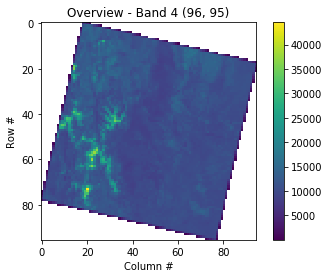

In [0]:
#URL address where the GeoTiff is located in this case is an aws server
filepath = 'http://landsat-pds.s3.amazonaws.com/c1/L8/232/083/LC08_L1TP_232083_20181231_20190130_01_T1/LC08_L1TP_232083_20181231_20190130_01_T1_B4.TIF'


with rasterio.open(filepath) as src:
    oviews = src.overviews(1)
    oview = oviews[-1]
    print('Decimation factor= {}'.format(oview))
    thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

    thumbnail = thumbnail.astype('f4')
    thumbnail[thumbnail==0] = np.nan

plt.imshow(thumbnail)
plt.colorbar()
plt.title('Overview - Band 4 {}'.format(thumbnail.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

## Require a subset
A subset is nothing more than a GeoTiff cut. The benefit of requesting a subset from the server is to bring only the area of interest from the server. In this way we avoid images of approx 1Gb and only process small subset. This GeoTiff is of maximum resolution unlike the overview.



Text(0, 0.5, 'Row #')

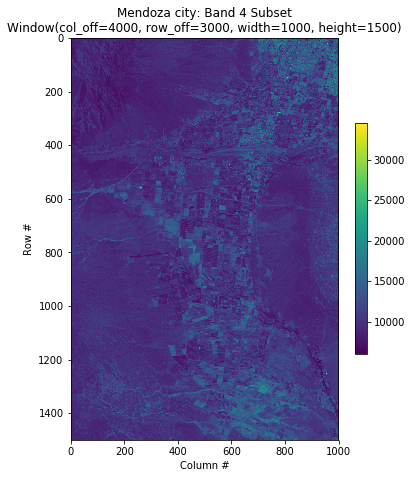

In [0]:
#URL address where the GeoTiff is located in this case is an aws server
filepath = 'http://landsat-pds.s3.amazonaws.com/c1/L8/232/083/LC08_L1TP_232083_20181231_20190130_01_T1/LC08_L1TP_232083_20181231_20190130_01_T1_B4.TIF'

#https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html
#rasterio.windows.Window(col_off, row_off, width, height)
window = rasterio.windows.Window(4000, 3000, 1000, 1500)

with rasterio.open(filepath) as src:
    subset = src.read(1, window=window)

plt.figure(figsize=(6,8.5))
plt.imshow(subset)
plt.colorbar(shrink=0.5)
plt.title(f'Mendoza city: Band 4 Subset\n{window}')
plt.xlabel('Column #')
plt.ylabel('Row #')

In profile, we saw several data, we can also obtain directly once a geoTiff is opened.

In [0]:
print("coordinates that define the box")
print(src.bounds)
print("Lower right corner coordinates")
print(src.transform * (src.width, src.height))

coordinates that define the box
BoundingBox(left=370485.0, bottom=-3788115.0, right=602715.0, top=-3554085.0)
Lower right corner coordinates
(602715.0, -3788115.0)


In [0]:
print("Transformation matrix, it contains coordinate information and meters per pixel")
src.transform 

Transformation matrix, it contains coordinate information and meters per pixel


Affine(30.0, 0.0, 370485.0,
       0.0, -30.0, -3554085.0)

In [0]:
print("Width and height in pixels of the GeoTiff")
print(src.width)
print(src.height)

Width and height in pixels of the GeoTiff
7741
7801


# NDVI
This example uses the **overviews images**. Overviews are only disponible in aws, Google Cloud dont have a overview.


## Open the Red Band

Overviews decimator factor:
[3, 9, 27, 81]
Decimation factor= 9


Text(0, 0.5, 'Row #')

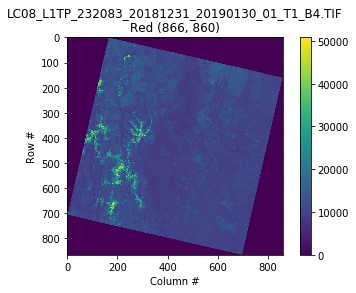

In [0]:
date = '2018-12-31'
#URL address where the GeoTiff is located in this case is an aws server
url = 'http://landsat-pds.s3.amazonaws.com/c1/L8/232/083/LC08_L1TP_232083_20181231_20190130_01_T1/'
#Band 4
redband = 'LC08_L1TP_232083_20181231_20190130_01_T1_B4.TIF'
#Band 5
nirband = 'LC08_L1TP_232083_20181231_20190130_01_T1_B5.TIF'


with rasterio.open(url+redband) as src:
  oviews = src.overviews(1) # list of overviews from biggest to smallest
  print("Overviews decimator factor:")
  print(oviews)
  oview = oviews[1]  # Use second-highest resolution overview, decimator 9
  print('Decimation factor= {}'.format(oview))
  red = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

plt.imshow(red)
plt.colorbar()
plt.title('{}\nRed {}'.format(redband, red.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

## Open the nRed Band

[3, 9, 27, 81]


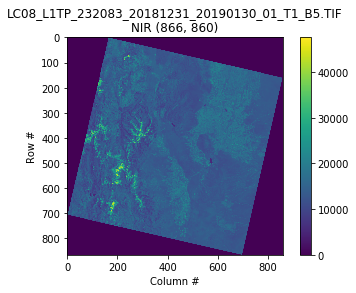

In [0]:
with rasterio.open(url+nirband) as src:
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    nir = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

plt.imshow(nir)
plt.colorbar()
plt.title('{}\nNIR {}'.format(nirband, nir.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

print(oviews)

## Get the NDVI

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Text(0, 0.5, 'Row #')

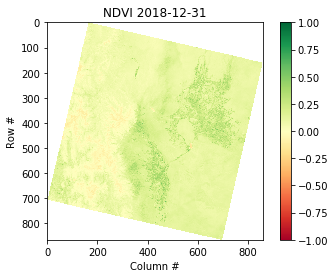

In [0]:
#function to calculate the ndvi
def calc_ndvi(nir,red):
    '''Calculate NDVI from integer arrays'''
    nir = nir.astype('f4')
    red = red.astype('f4')
    ndvi = (nir - red) / (nir + red)
    return ndvi

ndvi = calc_ndvi(nir,red)
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
plt.title('NDVI {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')

## Save the NDVI GeoTiff
The geoTiff will be stored in the folder where we are positioned at the time of executing the box.

In [0]:
print("Actual path: ")
!pwd

Actual path: 
/content


In [0]:
#name with which the GeoTiff will be saved
localname = 'test_mendoza.tif'

with rasterio.open(url+nirband) as src:
    #copy the profile of the original GeoTiff
    profile = src.profile.copy()  
    
    # Get the transform from the full size image
    aff = src.transform
    # Affect the transform matriz by the size of overview image
    newaff = rasterio.Affine(aff.a * oview, aff.b, aff.c,  
                             aff.d, aff.e * oview, aff.f)
    #Set the new profile for the NDVI image
    profile.update({
            'dtype': 'float32',
            'height': ndvi.shape[0],
            'width': ndvi.shape[1],
            'transform': newaff})  
    #Save
    with rasterio.open(localname, 'w', **profile) as dst:
        dst.write_band(1, ndvi)

### Re open NDVI for check

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 860, 'height': 866, 'count': 1, 'crs': CRS.from_epsg(32619), 'transform': Affine(270.0, 0.0, 370485.0,
       0.0, -270.0, -3554085.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


Text(0, 0.5, 'Row #')

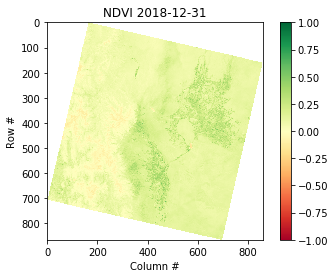

In [0]:
# Reopen the file and plot
with rasterio.open(localname) as src:
    print(src.profile)
    ndvi = src.read(1) # read the entire array

plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
plt.title('NDVI {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')

### Plot with rasterio
In the previous cells we were using the matplotlib library. In this case we will use the raster module to plot. Actually, Rasterio depends on matplotlib, so plotting with rasterio is simply the same as plotting with matplotlib only on one line (less plot control but faster to visualize a GeoTiff)

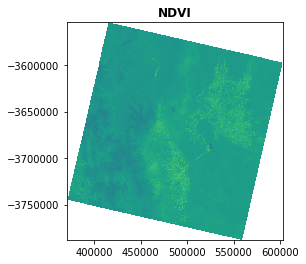

In [0]:
# in this case, coordinates are Easting [m] and Northing [m], and colorbar is default instead of RdYlGn
with rasterio.open(localname) as src:
    fig, ax = plt.subplots()
    rasterio.plot.show(src, ax=ax, title='NDVI')

# Import Drive
In this section, we will import Google Drive to Colab in order to save all processed NDVIs in the drive.
When executing the following box, you will be asked to enter a link, this is necessary to give Colab authorization to access our drive.
After authorizing the link, it gives us a code which must be pasted in the box.

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive

#Where to mount the drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Clipped Image

Get, plot and save a clipped image.

Make shure you import and mount Drive in Colab

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 1000, 'height': 1500, 'count': 1, 'crs': CRS.from_epsg(32619), 'transform': Affine(30.0, 0.0, 490485.0,
       0.0, -30.0, -3644085.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


Text(0, 0.5, 'Row #')

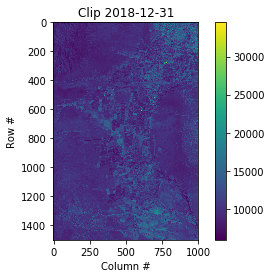

In [0]:
#URL address where the GeoTiff is located in this case is an aws server
filepath = 'http://landsat-pds.s3.amazonaws.com/c1/L8/232/083/LC08_L1TP_232083_20181231_20190130_01_T1/LC08_L1TP_232083_20181231_20190130_01_T1_B4.TIF'


##name with which the GeoTiff will be saved
localname = 'test_mendoza_clipp.tif'
#path in which the GeoTiff will be stored
path_save = '/content/drive/My Drive/'

#Create a window for our GeoTiff
#https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html
#rasterio.windows.Window(col_off, row_off, width, height)
window = rasterio.windows.Window(4000, 3000, 1000, 1500)

with rasterio.open(filepath) as src:
    #get subset
    subset = src.read(1, window=window)
    #copy the original profile
    profile = src.profile.copy()
    #update profile
    aff = src.window_transform(window)
    
    profile.update({
            'dtype': 'uint16',
            'height': subset.shape[0],
            'width': subset.shape[1],
            'transform': aff})  

    with rasterio.open(path_save + localname, 'w', **profile) as dst:
        dst.write_band(1, subset)
        
        
        
# Reopen the file and plot
with rasterio.open(path_save + localname) as src:
    print(src.profile)
    clip = src.read(1) # read the entire array

plt.imshow(clip)
plt.colorbar()
plt.title('Clip {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')

# Clipped NDVI
Get, Plot and save the NDVI of a window in Drive. 

Make shure you import and mount Drive in Colab


Text(0, 0.5, 'Row #')

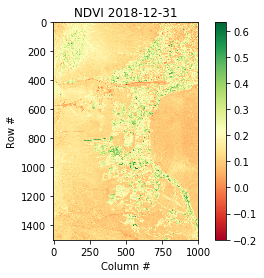

In [0]:
# NDVI from aws with clip:
date = '2018-12-31'
url = 'http://landsat-pds.s3.amazonaws.com/c1/L8/232/083/LC08_L1TP_232083_20181231_20190130_01_T1/'

#The name of the two band GeoTiff
redband = 'LC08_L1TP_232083_20181231_20190130_01_T1_B4.TIF'
nirband = 'LC08_L1TP_232083_20181231_20190130_01_T1_B5.TIF'

#target name of the file
localname = 'NDVI_test_mendoza_clipp.tif'
#path to save the file
path_save = '/content/drive/My Drive/'

#Define a window to reques to the server
#https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html
#rasterio.windows.Window(col_off, row_off, width, height)
window = rasterio.windows.Window(4000, 3000, 1000, 1500)



#function to calc NDVI
def calc_ndvi(nir,red):
    '''Calculate NDVI from integer arrays'''
    nir = nir.astype('f4')
    red = red.astype('f4')
    ndvi = (nir - red) / (nir + red)
    return ndvi


#open and assign the red band
with rasterio.open(url+redband) as src:
    red = src.read(1, window=window)
#open and assign the nir band
with rasterio.open(url+nirband) as src:
    nir = src.read(1, window=window)
    #update the profile for the window size
    profile = src.profile.copy()
    aff = src.window_transform(window)
    profile.update({
            'dtype': 'float32',
            'height': ndvi.shape[0],
            'width': ndvi.shape[1],
            'transform': aff})  

#Calculate NDVI
ndvi = calc_ndvi(nir,red)

#Save NDVI in drive
with rasterio.open(path_save + localname, 'w', **profile) as dst:
    dst.write_band(1, ndvi)

#plot the result
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
plt.title('NDVI {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')    

# Get a serie of NDVI images
De igual manera que el caso anterior solo que con una lista de GeoTiff a procesar

In [0]:
#As a test we use 6 GeoTiff
files = ('LC08_L1TP_232083_20190609_20190619_01_T1',
'LC08_L1TP_232083_20190524_20190604_01_T1',
'LC08_L1TP_232083_20190508_20190521_01_T1',
'LC08_L1TP_232083_20190422_20190507_01_T1',
'LC08_L1TP_232083_20190406_20190422_01_T1',
'LC08_L1TP_232083_20190321_20190403_01_T1')

#Rest of the list, can be added if desired, even clean and
#add more from the text cell at the end of the colab
''''LC08_L1TP_232083_20190305_20190309_01_T1',
'LC08_L1TP_232083_20190217_20190222_01_T1',
'LC08_L1TP_232083_20190201_20190206_01_T1',
'LC08_L1TP_232083_20190116_20190131_01_T1',
'LC08_L1TP_232083_20181231_20190130_01_T1',
'LC08_L1TP_232083_20181215_20181227_01_T1',
'LC08_L1TP_232083_20181129_20181211_01_T1',
'LC08_L1TP_232083_20181113_20181127_01_T1',
'LC08_L1TP_232083_20181028_20181115_01_T1',
'LC08_L1TP_232083_20181012_20181030_01_T1',
'LC08_L1TP_232083_20180926_20181009_01_T1',
'LC08_L1TP_232083_20180910_20180927_01_T1',
'LC08_L1TP_232083_20180825_20180829_01_T1',
'LC08_L1TP_232083_20180809_20180815_01_T1',
'LC08_L1TP_232083_20180724_20180731_01_T1',
'LC08_L1TP_232083_20180708_20180717_01_T1',
'LC08_L1TP_232083_20180622_20180703_01_T1',
'LC08_L1TP_232083_20180606_20180615_01_T1',
'LC08_L1TP_232083_20180521_20180605_01_T1',
'LC08_L1TP_232083_20180505_20180517_01_T1',
'LC08_L1TP_232083_20180419_20180502_01_T1',
'LC08_L1TP_232083_20180403_20180417_01_T1',
'LC08_L1TP_232083_20180318_20180403_01_T1',
'LC08_L1TP_232083_20180302_20180319_01_T1',
'LC08_L1TP_232083_20180214_20180222_01_T1',
'LC08_L1TP_232083_20180129_20180207_01_T1',
'LC08_L1TP_232083_20180113_20180119_01_T1',
'LC08_L1TP_232083_20171228_20180103_01_T1',
'LC08_L1TP_232083_20171212_20171223_01_T1',
'LC08_L1TP_232083_20171126_20171206_01_T1',
'LC08_L1TP_232083_20171110_20171121_01_T1',
'LC08_L1TP_232083_20171025_20171107_01_T1',
'LC08_L1TP_232083_20171009_20171024_01_T1',
'LC08_L1TP_232083_20170923_20171013_01_T1',
'LC08_L1TP_232083_20170907_20170926_01_T1',
'LC08_L1TP_232083_20170822_20170911_01_T1',
'LC08_L1TP_232083_20170806_20170813_01_T1',
'LC08_L1TP_232083_20170721_20170728_01_T1',
'LC08_L1TP_232083_20170619_20170629_01_T1') '''

#sanity check files to process
for file in  files:
  print(file)

LC08_L1TP_232083_20190609_20190619_01_T1
LC08_L1TP_232083_20190524_20190604_01_T1
LC08_L1TP_232083_20190508_20190521_01_T1
LC08_L1TP_232083_20190422_20190507_01_T1
LC08_L1TP_232083_20190406_20190422_01_T1
LC08_L1TP_232083_20190321_20190403_01_T1


In [0]:

# NDVI from aws with clip:
date = '2018-12-31'
url = 'http://landsat-pds.s3.amazonaws.com/c1/L8/232/083/'

#end of name for red and Nir band
redband = '_B4.TIF'
nirband = '_B5.TIF'

#target name of the file
localname = 'NDVI.tif'
#path to save the file
path_save = '/content/drive/My Drive/NDVIGeoTiff/'

#Define a window to reques to the server
#https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html
#rasterio.windows.Window(col_off, row_off, width, height)
window = rasterio.windows.Window(4000, 3000, 1000, 1500)



#function to calc NDVI
def calc_ndvi(nir,red):
    '''Calculate NDVI from integer arrays'''
    nir = nir.astype('f4')
    red = red.astype('f4')
    ndvi = (nir - red) / (nir + red)
    return ndvi

#loop over all the geotiff in the list "files"
for image in files:
  #logg message
  print('processing:' + 'NDVI_' + image + '.tif')
  
  #open and assign the red band
  with rasterio.open(url + image +'/'+ image + redband) as src:
    red = src.read(1, window=window)
    #update the profile for the window size
    profile = src.profile.copy()
    aff = src.window_transform(window)

    profile.update({
            'dtype': 'float32',
            'height': ndvi.shape[0],
            'width': ndvi.shape[1],
            'transform': aff})  
    
  #open and assign the nir band
  with rasterio.open(url + image +'/'+ image + nirband) as src:
    nir = src.read(1, window=window)

  #calculate the NDVI
  ndvi = calc_ndvi(nir,red)
  
  #Save NDVI in drive
  with rasterio.open(path_save + 'NDVI_'+ image + '.tif', 'w', **profile) as dst:
    dst.write_band(1, ndvi)

processing:NDVI_LC08_L1TP_232083_20190609_20190619_01_T1.tif
processing:NDVI_LC08_L1TP_232083_20190524_20190604_01_T1.tif
processing:NDVI_LC08_L1TP_232083_20190508_20190521_01_T1.tif
processing:NDVI_LC08_L1TP_232083_20190422_20190507_01_T1.tif
processing:NDVI_LC08_L1TP_232083_20190406_20190422_01_T1.tif
processing:NDVI_LC08_L1TP_232083_20190321_20190403_01_T1.tif



LC08_L1TP_232083_20190609_20190619_01_T1
LC08_L1TP_232083_20190524_20190604_01_T1
LC08_L1TP_232083_20190508_20190521_01_T1
LC08_L1TP_232083_20190422_20190507_01_T1
LC08_L1TP_232083_20190406_20190422_01_T1
LC08_L1TP_232083_20190321_20190403_01_T1
LC08_L1TP_232083_20190305_20190309_01_T1
LC08_L1TP_232083_20190217_20190222_01_T1
LC08_L1TP_232083_20190201_20190206_01_T1
LC08_L1TP_232083_20190116_20190131_01_T1
LC08_L1TP_232083_20181231_20190130_01_T1
LC08_L1TP_232083_20181215_20181227_01_T1
LC08_L1TP_232083_20181129_20181211_01_T1
LC08_L1TP_232083_20181113_20181127_01_T1
LC08_L1TP_232083_20181028_20181115_01_T1
LC08_L1TP_232083_20181012_20181030_01_T1
LC08_L1TP_232083_20180926_20181009_01_T1
LC08_L1TP_232083_20180910_20180927_01_T1
LC08_L1TP_232083_20180825_20180829_01_T1
LC08_L1TP_232083_20180809_20180815_01_T1
LC08_L1TP_232083_20180724_20180731_01_T1
LC08_L1TP_232083_20180708_20180717_01_T1
LC08_L1TP_232083_20180622_20180703_01_T1
LC08_L1TP_232083_20180606_20180615_01_T1
LC08_L1TP_232083_20180521_20180605_01_T1
LC08_L1TP_232083_20180505_20180517_01_T1
LC08_L1TP_232083_20180419_20180502_01_T1
LC08_L1TP_232083_20180403_20180417_01_T1
LC08_L1TP_232083_20180318_20180403_01_T1
LC08_L1TP_232083_20180302_20180319_01_T1
LC08_L1TP_232083_20180214_20180222_01_T1
LC08_L1TP_232083_20180129_20180207_01_T1
LC08_L1TP_232083_20180113_20180119_01_T1
LC08_L1TP_232083_20171228_20180103_01_T1
LC08_L1TP_232083_20171212_20171223_01_T1
LC08_L1TP_232083_20171126_20171206_01_T1
LC08_L1TP_232083_20171110_20171121_01_T1
LC08_L1TP_232083_20171025_20171107_01_T1
LC08_L1TP_232083_20171009_20171024_01_T1
LC08_L1TP_232083_20170923_20171013_01_T1
LC08_L1TP_232083_20170907_20170926_01_T1
LC08_L1TP_232083_20170822_20170911_01_T1
LC08_L1TP_232083_20170806_20170813_01_T1
LC08_L1TP_232083_20170721_20170728_01_T1
LC08_L1TP_232083_20170619_20170629_01_T1




LC08_L1TP_232083_20170603_20170615_01_T1 	Sat Jun 03 2017 	12%
LC08_L1TP_232083_20170603_20170603_01_RT 	Sat Jun 03 2017 	12%
LC08_L1GT_232083_20170518_20170518_01_RT 	Thu May 18 2017 	74%
LC08_L1TP_232083_20170502_20170515_01_T1 	Tue May 02 2017 	21%
LC08_L1TP_232083_20170416_20170501_01_T1 	Sun Apr 16 2017 	85%
LC08_L1TP_232083_20170331_20170414_01_T1 	Fri Mar 31 2017 	50%
LC08_L1TP_232083_20170315_20170328_01_T1 	Wed Mar 15 2017 	4%
LC08_L1TP_232083_20170227_20170316_01_T1 	Mon Feb 27 2017 	4%
LC08_L1TP_232083_20170211_20170217_01_T1 	Sat Feb 11 2017 	2%
LC08_L1TP_232083_20170126_20170214_01_T1 	Thu Jan 26 2017 	0%
LC08_L1TP_232083_20170110_20170311_01_T1 	Tue Jan 10 2017 	31%
LC08_L1TP_232083_20161225_20170315_01_T1 	Sun Dec 25 2016 	34%
LC08_L1TP_232083_20161123_20170318_01_T1 	Wed Nov 23 2016 	66%
LC08_L1TP_232083_20161107_20170318_01_T1 	Mon Nov 07 2016 	4%
LC08_L1TP_232083_20161022_20170319_01_T1 	Sat Oct 22 2016 	6%
LC08_L1TP_232083_20161006_20170320_01_T1 	Thu Oct 06 2016 	34%
LC08_L1TP_232083_20160920_20170321_01_T1 	Tue Sep 20 2016 	4%
LC08_L1TP_232083_20160904_20170321_01_T1 	Sun Sep 04 2016 	64%
LC08_L1TP_232083_20160819_20170322_01_T1 	Fri Aug 19 2016 	35%
LC08_L1TP_232083_20160803_20170322_01_T1 	Wed Aug 03 2016 	37%
LC08_L1TP_232083_20160718_20170323_01_T1 	Mon Jul 18 2016 	17%
LC08_L1TP_232083_20160702_20170323_01_T1 	Sat Jul 02 2016 	67%
LC08_L1TP_232083_20160616_20170324_01_T1 	Thu Jun 16 2016 	4%
LC08_L1TP_232083_20160531_20170324_01_T1 	Tue May 31 2016 	28%
LC08_L1TP_232083_20160515_20170324_01_T1 	Sun May 15 2016 	42%
LC08_L1TP_232083_20160429_20170326_01_T1 	Fri Apr 29 2016 	70%
LC08_L1TP_232083_20160413_20170326_01_T1 	Wed Apr 13 2016 	56%
LC08_L1TP_232083_20160328_20170327_01_T1 	Mon Mar 28 2016 	8%
LC08_L1TP_232083_20160312_20170328_01_T1 	Sat Mar 12 2016 	31%
LC08_L1TP_232083_20160225_20170329_01_T1 	Thu Feb 25 2016 	14%
LC08_L1TP_232083_20160209_20170330_01_T1 	Tue Feb 09 2016 	8%
LC08_L1TP_232083_20160124_20170405_01_T1 	Sun Jan 24 2016 	48%
LC08_L1TP_232083_20160108_20170405_01_T1 	Fri Jan 08 2016 	53%
LC08_L1TP_232083_20151223_20170331_01_T1 	Wed Dec 23 2015 	12%
LC08_L1TP_232083_20151207_20170401_01_T1 	Mon Dec 07 2015 	20%
LC08_L1TP_232083_20151121_20170401_01_T1 	Sat Nov 21 2015 	18%
LC08_L1TP_232083_20151105_20170402_01_T1 	Thu Nov 05 2015 	44%
LC08_L1TP_232083_20151020_20170403_01_T1 	Tue Oct 20 2015 	28%
LC08_L1TP_232083_20151004_20170403_01_T1 	Sun Oct 04 2015 	100%
LC08_L1TP_232083_20150918_20170404_01_T1 	Fri Sep 18 2015 	8%
LC08_L1TP_232083_20150902_20170404_01_T1 	Wed Sep 02 2015 	3%
LC08_L1TP_232083_20150817_20170406_01_T1 	Mon Aug 17 2015 	1%
LC08_L1TP_232083_20150801_20170406_01_T1 	Sat Aug 01 2015 	35%
LC08_L1TP_232083_20150716_20170407_01_T1 	Thu Jul 16 2015 	21%
LC08_L1TP_232083_20150630_20170407_01_T1 	Tue Jun 30 2015 	33%
LC08_L1TP_232083_20150614_20170408_01_T1 	Sun Jun 14 2015 	10%
LC08_L1TP_232083_20150529_20170408_01_T1 	Fri May 29 2015 	20%
LC08_L1TP_232083_20150513_20170409_01_T1 	Wed May 13 2015 	6%
LC08_L1TP_232083_20150427_20170409_01_T1 	Mon Apr 27 2015 	26%
LC08_L1TP_232083_20150411_20170410_01_T1 	Sat Apr 11 2015 	12%
LC08_L1TP_232083_20150326_20170411_01_T1 	Thu Mar 26 2015 	87%
LC08_L1TP_232083_20150310_20170412_01_T1 	Tue Mar 10 2015 	10%
LC08_L1TP_232083_20150222_20170412_01_T1 	Sun Feb 22 2015 	4%
LC08_L1TP_232083_20150206_20170413_01_T1 	Fri Feb 06 2015 	32%
LC08_L1TP_232083_20150121_20170413_01_T1 	Wed Jan 21 2015 	13%
LC08_L1TP_232083_20150105_20170415_01_T1 	Mon Jan 05 2015 	1%
LC08_L1TP_232083_20141220_20170416_01_T1 	Sat Dec 20 2014 	31%
LC08_L1TP_232083_20141204_20170416_01_T1 	Thu Dec 04 2014 	1%
LC08_L1TP_232083_20141118_20170417_01_T1 	Tue Nov 18 2014 	30%
LC08_L1TP_232083_20141102_20170418_01_T1 	Sun Nov 02 2014 	83%
LC08_L1TP_232083_20141017_20170418_01_T1 	Fri Oct 17 2014 	29%
LC08_L1TP_232083_20141001_20170418_01_T1 	Wed Oct 01 2014 	41%
LC08_L1TP_232083_20140915_20170419_01_T1 	Mon Sep 15 2014 	6%
LC08_L1TP_232083_20140830_20170420_01_T1 	Sat Aug 30 2014 	38%
LC08_L1TP_232083_20140814_20170420_01_T1 	Thu Aug 14 2014 	44%
LC08_L1TP_232083_20140729_20170420_01_T1 	Tue Jul 29 2014 	32%
LC08_L1TP_232083_20140713_20170421_01_T1 	Sun Jul 13 2014 	9%
LC08_L1TP_232083_20140627_20170421_01_T1 	Fri Jun 27 2014 	5%
LC08_L1TP_232083_20140611_20170422_01_T1 	Wed Jun 11 2014 	52%
LC08_L1TP_232083_20140526_20170422_01_T1 	Mon May 26 2014 	5%
LC08_L1TP_232083_20140510_20170422_01_T1 	Sat May 10 2014 	64%
LC08_L1TP_232083_20140424_20170423_01_T1 	Thu Apr 24 2014 	33%
LC08_L1TP_232083_20140408_20170424_01_T1 	Tue Apr 08 2014 	2%
LC08_L1TP_232083_20140323_20170424_01_T1 	Sun Mar 23 2014 	1%
LC08_L1TP_232083_20140307_20170425_01_T1 	Fri Mar 07 2014 	3%
LC08_L1TP_232083_20140219_20170425_01_T1 	Wed Feb 19 2014 	7%
LC08_L1TP_232083_20140203_20170426_01_T1 	Mon Feb 03 2014 	36%
LC08_L1TP_232083_20140118_20170426_01_T1 	Sat Jan 18 2014 	94%
LC08_L1TP_232083_20140102_20170427_01_T1 	Thu Jan 02 2014 	14%
LC08_L1TP_232083_20131217_20170427_01_T1 	Tue Dec 17 2013 	8%
LC08_L1TP_232083_20131201_20170428_01_T1 	Sun Dec 01 2013 	3%
LC08_L1TP_232083_20131115_20170428_01_T1 	Fri Nov 15 2013 	3%
LC08_L1TP_232083_20130928_20170502_01_T1 	Sat Sep 28 2013 	55%
LC08_L1TP_232083_20130912_20170502_01_T1 	Thu Sep 12 2013 	61%
LC08_L1TP_232083_20130827_20170502_01_T1 	Tue Aug 27 2013 	4%
LC08_L1TP_232083_20130811_20170503_01_T1 	Sun Aug 11 2013 	54%
LC08_L1TP_232083_20130726_20170503_01_T1 	Fri Jul 26 2013 	45%
LC08_L1TP_232083_20130710_20170504_01_T1 	Wed Jul 10 2013 	78%
LC08_L1TP_232083_20130624_20170504_01_T1 	Mon Jun 24 2013 	5%
LC08_L1TP_232083_20130608_20170504_01_T1 	Sat Jun 08 2013 	4%
LC08_L1TP_232083_20130523_20170504_01_T1 	Thu May 23 2013 	5%
LC08_L1TP_232083_20130421_20170505_01_T1 	Sun Apr 21 2013 	1%
LC08_L1TP_232083_20130407_20170505_01_T1 	Sun Apr 07 2013 	4%
LC08_L1TP_232083_20130402_20170505_01_T1 	Tue Apr 02 2013 	16%